In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import collections
import cv2
import matplotlib.pyplot as plt
import gym

In [2]:
def plot_learning_curve(xlabel, ylabel, x, y, filename, epsilons=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    if epsilons is not None:
        ax.plot(x, epsilons, color="C0")
        ax.set_xlabel(xlabel, color="C0")
        ax.set_ylabel("Epsilon", color="C0")
        ax.tick_params(axis='x', colors="C0")
        ax.tick_params(axis='y', colors="C0")
    else:
        ax.axes.get_xaxis().set_visible(False)
    N = len(y)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(y[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    # ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel(ylabel, color="C1")
    ax2.set_xlabel(xlabel, color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")
    plt.savefig(filename)

# klasa odpowiada za powtarzanie wybranej akcji na 4 klatkach
# klasa również łączy 2 ostatnie klatki, ponieważ biblioteka gym wyświetla niektóre obiekty tylko na
# przystych klatkach, a inne tylko na nieparzystych klatkach
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.last2_frames_buffer = np.zeros_like((2, self.shape))

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            t_reward += reward
            idx = i % 2
            self.last2_frames_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.last2_frames_buffer[0], self.last2_frames_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        self.last2_frames_buffer = np.zeros_like((2,self.shape))
        self.last2_frames_buffer[0] = obs
        return obs

class PreprocessStackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat, shape):
        super(PreprocessStackFrames, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                shape=(self.shape[0]*repeat, self.shape[1], self.shape[2]), dtype=np.float32)
        self.stack = collections.deque(maxlen=repeat)

# konwertowanie klatki na odcienie szarości, zeskalowanie do wartości 0-1, skalowanie do 84x84x1
    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        new_frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = np.interp(new_obs, [0, 255], [0, 1])
        for _ in range(self.stack.maxlen):
            self.stack.append(new_obs)
        return np.array(self.stack).reshape(self.observation_space.low.shape)

# konwertowanie na odcienie szarosci, skalowanie do 84x84x1 i wartości do 0-1
    def observation(self, observation):
        new_frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0
        self.stack.append(new_obs)
        return np.array(self.stack).reshape(self.observation_space.low.shape)

def make_env(env_name, shape=(84,84,1), repeat=4):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat)
    env = PreprocessStackFrames(env, repeat, shape)

    return env

In [3]:
class AgentReplayBuffer:
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.memory_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                            dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                            dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    # przechowanie pamięci w pierwszych niezapełnionych miejscach zgodnie z tym co jest w artykule
    def store_transition(self, state, action, reward, state_, done):
        # pierwsze wolne miejsce
        index = self.memory_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.memory_counter += 1

# losowe pobieranie próbki danych z zapisanej historii 50000
    def sample_batch(self, batch_size):
        max_mem = min(self.memory_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [4]:
# siec taka sama jak w artykule
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(DeepQNetwork, self).__init__()
        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = T.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

In [5]:
class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_counter = replace
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.loss = 0

        self.memory = AgentReplayBuffer(mem_size, input_dims)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = self.memory.sample_batch(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_counter == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if self.memory.memory_counter < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        self.loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        self.loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

C:\Users\patry\anaconda3\envs\DQN\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


episode:  0 score:  -21.0  average score -21.0 best score -inf epsilon 0.99 steps 764
episode:  1 score:  -21.0  average score -21.0 best score -21.00 epsilon 0.98 steps 1557
episode:  2 score:  -19.0  average score -20.3 best score -21.00 epsilon 0.97 steps 2561
episode:  3 score:  -20.0  average score -20.2 best score -20.33 epsilon 0.97 steps 3427
episode:  4 score:  -21.0  average score -20.4 best score -20.25 epsilon 0.96 steps 4210
episode:  5 score:  -20.0  average score -20.3 best score -20.25 epsilon 0.95 steps 5081
episode:  6 score:  -21.0  average score -20.4 best score -20.25 epsilon 0.94 steps 5873
episode:  7 score:  -20.0  average score -20.4 best score -20.25 epsilon 0.93 steps 6963
episode:  8 score:  -20.0  average score -20.3 best score -20.25 epsilon 0.92 steps 8006
episode:  9 score:  -21.0  average score -20.4 best score -20.25 epsilon 0.91 steps 8879
episode:  10 score:  -21.0  average score -20.5 best score -20.25 epsilon 0.90 steps 9703
episode:  11 score:  -1

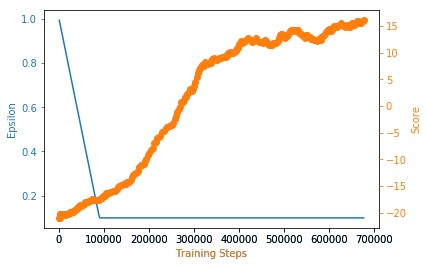

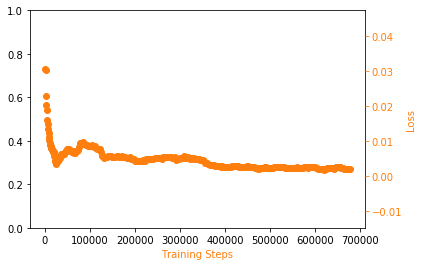

In [6]:
if __name__ == '__main__':
    env = make_env('PongNoFrameskip-v4')
    best_score = -np.inf
    load_checkpoint = False
    n_games = 300

    agent = DQNAgent(gamma=0.99, epsilon=1, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=50000, eps_min=0.1,
                     batch_size=32, replace=1000, eps_dec=1e-5)

    n_steps = 0
    scores, eps_history, steps_array, loss_history = [], [], [], []

    for i in range(n_games):
        done = False
        observation = env.reset()

        score = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
            n_steps += 1
        scores.append(score)
        steps_array.append(n_steps)
        eps_history.append(agent.epsilon)
        loss_history.append(agent.loss)

        avg_score = np.mean(scores[-100:])
        print('episode: ', i,'score: ', score,
             ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
            'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

        if avg_score > best_score:
            best_score = avg_score

    loss_history = [loss.item() if isinstance(loss, T.Tensor) else loss for loss in loss_history]
    x = [i+1 for i in range(len(scores))]
    plot_learning_curve("Training Steps", "Score", steps_array, scores, "DQN_score_epsilon.png", epsilons=eps_history)
    plot_learning_curve("Training Steps", "Loss", steps_array, loss_history, "DQN_loss.png")
